In [14]:
import numpy as np
import pandas as pd
import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.datasets import load_digits
from IPython.display import display, HTML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import math, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, Reshape, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, ZeroPadding2D
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer, StandardScaler
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [6]:
np.random.seed(0)
hyperparameters = {
    'tree': {

        'max_depth': [2, 4, 8, 16, 32, 64, 128, None],
        'min_samples_split':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
        'min_samples_leaf':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],


    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf', 'linear', 'poly']
    },
    'KNN': {
        'n_neighbors': np.arange(1, 10, 1)
    },
    'adaboost': {
        'n_estimators': np.arange(1, 150, 10),

    }

}

In [16]:
def load_data():
    data_directory = "../data/"
    filename = "diabetes.csv"
    df = pd.read_csv(data_directory + filename)
    
    plt.show()
    cols = list(df.columns.values)
    cols.remove('Outcome')
    X = (df[cols]).values
    y = df['Outcome'].values
    #scaler = StandardScaler()
    #scaler.fit(X)
    #X = scaler.transform(X)
    
    #plt.savefig("./output/label_count_mnist.png")
    return(X, y)

def split_data(X, y, data_size=1.0, train_size=0.8, strat=False):
    if strat:
        sss = StratifiedShuffleSplit(n_splits=1, random_state=0, train_size=train_size, test_size=train_size/4)
        for train_index, test_index in sss.split(X, y):
            print("hm")
            X_train = X[train_index]
            X_test = X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=train_size/4)
    return(X_train, y_train, X_test, y_test)


In [17]:
X, y = load_data()



In [18]:
X_train, X_holdout_test, y_train, y_holdout_test = train_test_split(X, y, test_size=0.2)
X_train, y_train, X_test, y_test = split_data(X_train, y_train, train_size=0.8)
print(X_train.shape)
print(X_test.shape)
print(X_holdout_test.shape)

(491, 8)
(123, 8)
(154, 8)


In [19]:

def test_hyperparams(classifier, range, args, arg_to_iterate):
    train_accs = []
    test_accs = []
    a = args

    for i in range:
        a[arg_to_iterate] = i
        clf = classifier(**a)
        clf = clf.fit(X_train, y_train)
        train_score = clf.score(X_train, y_train)
        test_score =clf.score(X_test, y_test)
        #print("i=%d, accuracy=%.2f%%" % (i, test_score * 100))
        train_accs.append(train_score* 100)
        test_accs.append(test_score* 100)
        best_metric = range[np.argmax(test_accs)]
    return test_accs, train_accs, best_metric

def plot_hyperparam_test(test_accs, train_accs, n_range, dataset, model_name, param_name, hist=False):

    plt.plot(n_range, train_accs, label = "train acc")
    plt.plot(n_range, test_accs, label = "test acc")
    plt.legend()

    plt.xlabel(param_name)
    plt.ylabel("test accuracy")
    title = "" + model_name + " score for " + param_name
    plt.title(title)
    plt.show()
    plt.savefig("./output/" + dataset + "-" + model_name + "-" + param_name + ".png")

def run_gridsearchCV(classifier, params, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(classifier, param_grid=params, cv=5, verbose=10, n_jobs=-1)
    grid.fit(X_train, y_train)
    train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_test, y_test)
    return(train_score, test_score, grid.best_params_)

def tune_knn(X_train, y_train, X_test, y_test):
    kVals = np.arange(1, 100, 1)
    gscv_train, gscv_test, best_params = run_gridsearchCV(
        KNeighborsClassifier(),
        {
            'n_neighbors': kVals,
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball', 'kd_tree', 'brute']
        },
        X_train, y_train, X_test, y_test
    )
    print(gscv_train)
    print(gscv_test)
    print(best_params)
    
def tune_decision_tree(X_train, y_train, X_test, y_test):
    kVals = np.arange(1, 30, 1)
    gscv_train, gscv_test, best_params = run_gridsearchCV(
        tree.DecisionTreeClassifier(),
        {
           'max_depth': [2, 4, 8, 16, 32, 64, 128, None],
            'min_samples_split':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
            'min_samples_leaf':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
        },
        X_train, y_train, X_test, y_test
    )
    print(gscv_train)
    print(gscv_test)
    print(best_params)
    
def tune_SVM(X_train, y_train, X_test, y_test):
    kVals = np.arange(1, 30, 1)
    gscv_train, gscv_test, best_params = run_gridsearchCV(
        SVC(),
        {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf', 'linear', 'poly']
        },
        X_train, y_train, X_test, y_test
    )
    print(gscv_train)
    print(gscv_test)
    print(best_params)
    
def tune_adaboost(X_train, y_train, X_test, y_test):
    kVals = np.arange(1, 30, 1)
    
    params = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "base_estimator__max_depth" :   np.arange(2, 12, 1),
                  "n_estimators": np.arange(1, 150, 10)
                 }


  
    clf = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto"))
    
    gscv_train, gscv_test, best_params = run_gridsearchCV(
        clf,
        params,
        X_train, y_train, X_test, y_test
    )
    print(gscv_train)
    print(gscv_test)
    print(best_params)





# KNN

In [37]:
tune_knn(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 792 candidates, totalling 3960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0179s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0618s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0558s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0828s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch com

0.7739307535641547
0.7479674796747967
{'weights': 'uniform', 'n_neighbors': 57, 'algorithm': 'auto'}


[Parallel(n_jobs=-1)]: Done 3585 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 3736 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 3960 out of 3960 | elapsed:    1.8s finished


In [41]:
params = {
    'n_neighbors': 1
}
n_range = np.arange(1, 100, 1)

test_accs, train_accs, best_metric = test_hyperparams(KNeighborsClassifier, 
                                                      n_range, 
                                                      params,
                                                      'n_neighbors' 
                                                     )
print(test_accs)
print(train_accs)
print(best_metric)

[76.42276422764228, 67.47967479674797, 73.98373983739837, 71.54471544715447, 74.79674796747967, 71.54471544715447, 72.35772357723577, 73.17073170731707, 74.79674796747967, 73.98373983739837, 76.42276422764228, 73.17073170731707, 75.60975609756098, 74.79674796747967, 75.60975609756098, 73.17073170731707, 75.60975609756098, 75.60975609756098, 78.04878048780488, 77.23577235772358, 77.23577235772358, 74.79674796747967, 75.60975609756098, 75.60975609756098, 76.42276422764228, 76.42276422764228, 77.23577235772358, 78.04878048780488, 78.04878048780488, 75.60975609756098, 77.23577235772358, 75.60975609756098, 75.60975609756098, 74.79674796747967, 74.79674796747967, 73.98373983739837, 75.60975609756098, 73.98373983739837, 75.60975609756098, 74.79674796747967, 75.60975609756098, 74.79674796747967, 74.79674796747967, 73.98373983739837, 73.98373983739837, 73.17073170731707, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796747967, 74.79674796

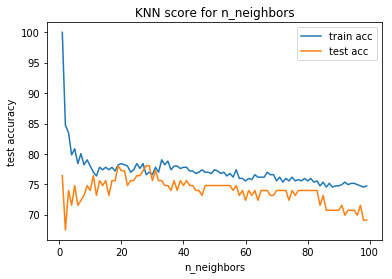

<Figure size 432x288 with 0 Axes>

In [42]:
n_range = np.arange(1, 100, 1)
plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "KNN", "n_neighbors")

In [44]:
model = KNeighborsClassifier(n_neighbors=29)
model.fit(X_train,y_train)
y_pred = model.predict(X_holdout_test)
knn_test_acc = metrics.accuracy_score(y_holdout_test, y_pred)
print(metrics.accuracy_score(y_holdout_test, y_pred))

0.6818181818181818


# Decision tree

In [45]:
tune_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1800s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0329s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0499s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed: 

0.8085539714867617
0.6829268292682927
{'min_samples_split': 4, 'min_samples_leaf': 32, 'max_depth': 4}


[Parallel(n_jobs=-1)]: Done 3161 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 3499 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3522 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3673 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 3950 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3977 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    2.9s finished


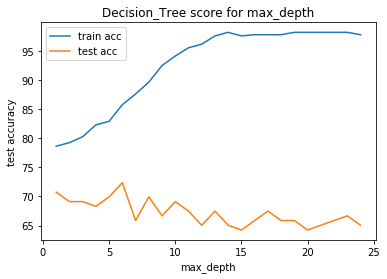

test acc:  [70.73170731707317, 69.10569105691057, 69.10569105691057, 68.29268292682927, 69.91869918699187, 72.35772357723577, 65.85365853658537, 69.91869918699187, 66.66666666666666, 69.10569105691057, 67.47967479674797, 65.04065040650406, 67.47967479674797, 65.04065040650406, 64.22764227642277, 65.85365853658537, 67.47967479674797, 65.85365853658537, 65.85365853658537, 64.22764227642277, 65.04065040650406, 65.85365853658537, 66.66666666666666, 65.04065040650406]
train acc:  [78.61507128309573, 79.22606924643586, 80.24439918533605, 82.28105906313645, 82.89205702647658, 85.74338085539715, 87.57637474541752, 89.61303462321793, 92.4643584521385, 94.09368635437882, 95.5193482688391, 96.13034623217924, 97.5560081466395, 98.16700610997964, 97.5560081466395, 97.75967413441956, 97.75967413441956, 97.75967413441956, 98.16700610997964, 98.16700610997964, 98.16700610997964, 98.16700610997964, 98.16700610997964, 97.75967413441956]
6


<Figure size 432x288 with 0 Axes>

In [60]:
params ={'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}
n_range = np.arange(1,25, 1)

test_accs, train_accs, best_metric = test_hyperparams(tree.DecisionTreeClassifier, 
                                                      n_range, 
                                                      params,
                                                      'max_depth' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "Decision_Tree", "max_depth")
print("test acc: ", test_accs)
print("train acc: ", train_accs)
print(best_metric)

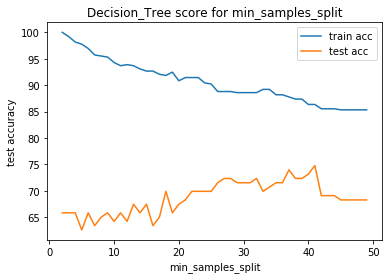

41


<Figure size 432x288 with 0 Axes>

In [61]:
n_range = np.arange(2, 50, 1)

test_accs, train_accs, best_metric = test_hyperparams(tree.DecisionTreeClassifier, 
                                                      n_range, 
                                                      params,
                                                      'min_samples_split' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "Decision_Tree", "min_samples_split")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)

In [32]:
params['min_samples_split'] = 39

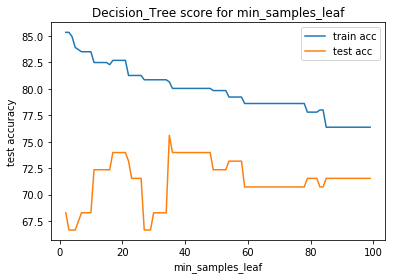

35


<Figure size 432x288 with 0 Axes>

In [63]:
n_range = np.arange(2, 100, 1)

test_accs, train_accs, best_metric = test_hyperparams(tree.DecisionTreeClassifier, 
                                                      n_range, 
                                                      params,
                                                      'min_samples_leaf' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "Decision_Tree", "min_samples_leaf")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)

In [34]:
params['min_samples_leaf'] = 4

In [65]:
params ={'max_depth': 6,'min_samples_leaf':35}
clf = tree.DecisionTreeClassifier(**params)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_holdout_test)
print(metrics.accuracy_score(y_holdout_test, y_pred))
decision_tree_test_acc = metrics.accuracy_score(y_holdout_test, y_pred)

0.7012987012987013


# SVM

In [66]:
tune_SVM(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1917s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0312s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0668s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0937s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 202 

0.8065173116089613
0.7560975609756098
{'kernel': 'rbf', 'C': 100, 'gamma': 0.001}


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:  8.7min finished


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

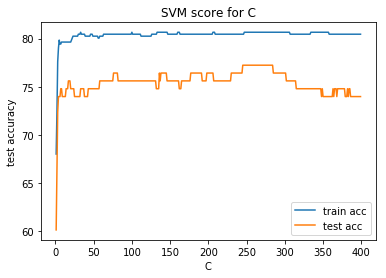

245


<Figure size 432x288 with 0 Axes>

In [75]:
#params = {
   # 'C': [0.1, 1, 10, 100, 1000],
  #  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 #   'kernel': ['rbf', 'linear', 'poly']
#}
params = {
    'C': 400,
    'gamma': 0.001,
    'kernel': 'rbf'
}
#0.1, 0.5,
n_range = [ 1, 2.5, 5, 7.5, 10]
n_range = np.arange(1, 400, 1)
print(n_range)
test_accs, train_accs, best_metric = test_hyperparams(SVC, 
                                                      n_range, 
                                                      params,
                                                      'C' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "SVM", "C")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['C'] = best_metric

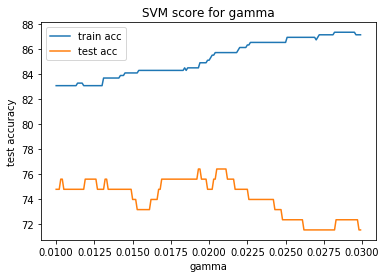

0.019299999999999942


<Figure size 432x288 with 0 Axes>

In [93]:
params = {
    'C': 400,
    'gamma': 0.001,
    'kernel': 'rbf'
}
n_range = [0.03, 0.02, 0.01, 0.001, 0.0001]
n_range = np.arange(0.01, 0.03, 0.0001)
test_accs, train_accs, best_metric = test_hyperparams(SVC, 
                                                      n_range, 
                                                      params,
                                                      'gamma' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "SVM", "gamma")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['gamma'] = best_metric

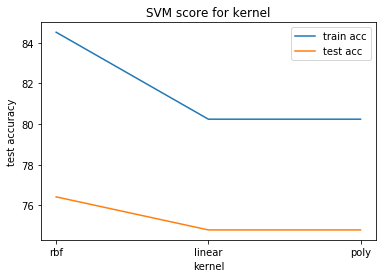

rbf


<Figure size 432x288 with 0 Axes>

In [105]:
n_range = ['rbf', 'linear', 'poly']
test_accs, train_accs, best_metric = test_hyperparams(SVC, 
                                                      n_range, 
                                                      params,
                                                      'kernel' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "SVM", "kernel")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['kernel'] = best_metric

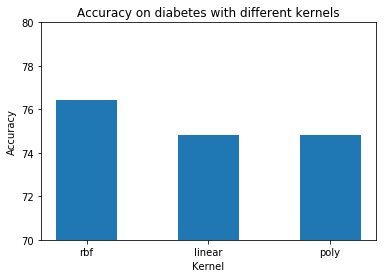

[76.42276422764228, 74.79674796747967, 74.79674796747967]


<Figure size 432x288 with 0 Axes>

In [109]:
plt.bar(n_range, test_accs, width=0.5)
plt.xlabel("Kernel")
plt.ylabel("Accuracy")
plt.title("Accuracy on diabetes with different kernels")
axes = plt.gca()
axes.set_ylim([70,80])

plt.show()
plt.savefig("./output/kernel_bars_mnist.png")
print(test_accs)

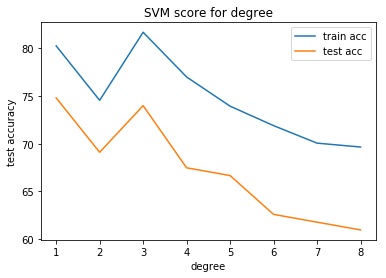

test acc:  [74.79674796747967, 69.10569105691057, 73.98373983739837, 67.47967479674797, 66.66666666666666, 62.601626016260155, 61.78861788617886, 60.97560975609756]
1


<Figure size 432x288 with 0 Axes>

In [101]:
params['kernel'] = 'poly'
params['degree'] = 1

n_range = np.arange(1, 9, 1)
test_accs, train_accs, best_metric = test_hyperparams(SVC, 
                                                      n_range, 
                                                      params,
                                                      'degree' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "SVM", "degree")
print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['degree'] = best_metric

In [110]:
params['kernel'] = 'rbf'

clf = SVC(**params)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_holdout_test)
print(metrics.accuracy_score(y_holdout_test, y_pred))
svm_test_acc = metrics.accuracy_score(y_holdout_test, y_pred)

0.6753246753246753


# ADABOOST

In [111]:
tune_adaboost(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

1.0
0.7317073170731707
{'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 6, 'base_estimator__splitter': 'best', 'n_estimators': 111}


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   49.3s finished


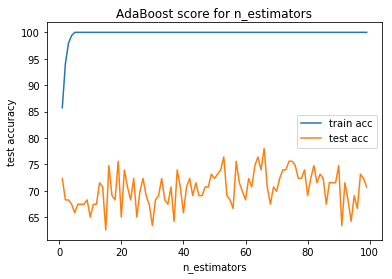

66


<Figure size 432x288 with 0 Axes>

In [117]:
#params ={'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1}
base_estimator = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=4)
params = {'n_estimators': 111, 'base_estimator':base_estimator}

n_range = np.arange(1, 100, 1)
test_accs, train_accs, best_metric = test_hyperparams(AdaBoostClassifier, 
                                                      n_range, 
                                                      params,
                                                      'n_estimators' 
                                                     )

plot_hyperparam_test(test_accs, train_accs, n_range,  "MNIST", "AdaBoost", "n_estimators")
#print("test acc: ", test_accs)
#print("train acc: ", train_accs)
print(best_metric)
params['n_estimators'] = best_metric

In [89]:
print("test acc: ", test_accs)

test acc:  [75.453446191052, 85.36880290205562, 88.27085852478838, 89.35912938331319, 90.81015719467956, 91.41475211608223, 91.53567110036276, 92.86577992744861, 93.47037484885126, 93.10761789600967, 93.5912938331318, 92.62394195888754, 93.5912938331318, 93.10761789600967, 94.19588875453447]


In [132]:
params = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "base_estimator__max_depth" :   np.arange(2, 12, 1),
                  "n_estimators": np.arange(1, 150, 10)
                 }


  
clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=8), n_estimators=250)
clf.fit(X_train, y_train)                                                                     
y_pred = clf.predict(X_holdout_test)
print(metrics.accuracy_score(y_holdout_test, y_pred))
adaboost_test_acc = metrics.accuracy_score(y_holdout_test, y_pred)

0.6883116883116883


# CNN

In [11]:
from keras.applications.vgg16 import VGG16, preprocess_input


Using TensorFlow backend.


In [84]:
#num_category = 10 

#y_train_oh = keras.utils.to_categorical(y_train, num_category)
#y_test_oh = keras.utils.to_categorical(y_test, num_category)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_33 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_55 (Dense)             (None, 8)                 72        
_________________________________________________________________
batch_normalization_13 (Batc (None, 8)                 32        
_________________________________________________________________
dense_56 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 17        
Total params: 337
Trainable params: 321
Non-trainable params: 16
_________________________________________________________________


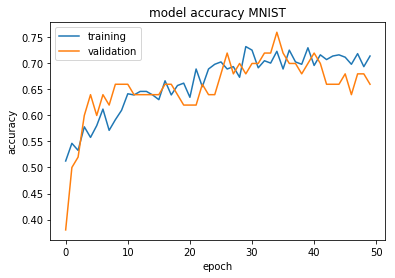

Test loss:  0.7604246236444488
Test accuracy:  0.7479674859744746


In [32]:
model = keras.models.Sequential()
model.add(Dense(8, activation='relu', kernel_regularizer=l2(.1), input_dim = X_train.shape[1]))
model.add(Dense(8, activation='relu', kernel_regularizer=l2(.05)))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
loss_fn = keras.losses.binary_crossentropy

model.compile(loss=loss_fn,
                  optimizer=opt,
                  metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=16, epochs=50, verbose=False, validation_split=.1)
loss, accuracy  = model.evaluate(X_test, y_test, verbose=False)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy MNIST')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print('Test loss: ', loss)
print('Test accuracy: ', accuracy)
